## DATA 622 - Homework 2
Derek G Nokes

Import packages

In [2818]:
import matplotlib.pyplot as plt
import seaborn
# inline matplotlib
%matplotlib inline

import pandas
import numpy
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pickle
#import fancyimpute

Define data locations and random seed:

In [2819]:
#output_directory='C:/Users/Derek/Documents/code/python/'
output_directory='/home/dnokes/projects/ms/data_622/hw2/'
#output_directory='C:/Users/derek/OneDrive/Documents/GitHub/DATA 622/hw2/'
login_filename='login'
output_file_train='train.csv'
output_file_test='test.csv'
login_url = 'https://www.kaggle.com/account/login'
data_train_url = 'https://www.kaggle.com/c/titanic/download/train.csv'
data_test_url = 'https://www.kaggle.com/c/titanic/download/test.csv'
randomSeed=123456789

# Exploratory Data Analysis (EDA)

Read in training data

In [2820]:
train_df = pandas.read_csv(output_directory+output_file_train)

We can see that there are some fields with a significant number null values, particularly 'Age' and 'Cabin':

In [2821]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Examining the first 5 rows of the training data set we can see that we have both categorical and continuous variables

In [2822]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Name contains titles and can likely be transformed into categorical variables.

### Addressing Missing Values

We examine the composition of missing data:

In [2823]:
# find number of missing values by column
nMissingByColumn=train_df.isnull().sum(axis=0)
# find number of values by column
nByColumn=train_df.isnull().count(axis=0)
# compute missing percent by column
missingPercentByColumn=nMissingByColumn/nByColumn

Plot the proportion of data missing for variables with missing data:

Cabin       77.104377
Age         19.865320
Embarked     0.224467
dtype: float64

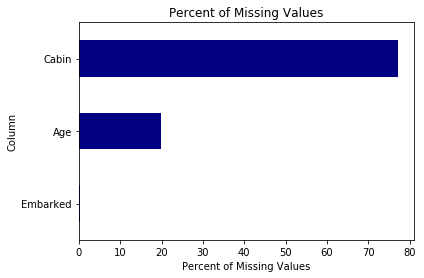

In [2824]:
# plot missing data by column
(missingPercentByColumn[missingPercentByColumn!=0]*100).sort_values(ascending=True).plot(kind='barh',
    title='Percent of Missing Values',color='navy')
plt.ylabel('Column')
plt.xlabel('Percent of Missing Values')
# display
(missingPercentByColumn[missingPercentByColumn!=0]*100).sort_values(ascending=False)

We can see that 'Cabin' is missing for almost 80% of training set passengers.



Looking more closely at the 'Cabin' field we can see that beginning of the field contains a letter, which perhaps corresponds to room location on the ship. It seems reasonable to assume that levels further below deck have lower fares and are occupied by lower class people. If there is a strong relationship between fare and cabin letter or class and cabin letter than we can potentially drop the cabin letter without degrading our classifier.

In [2825]:
# find rows with missing cabin
cabinMissingIndex=train_df['Cabin'].isnull()
# index into first 5 cabin values
train_df['Cabin'].loc[~cabinMissingIndex].head()


1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

Define a function to extract the number of rooms from the Cabin

In [2826]:
def nRooms(x):
    try:
        n=len(x)
    except:
        n=x
    return n

# remove room numbers and split on space
train_df['Level']=train_df['Cabin'].str.replace('\d+','').str.split()
# find number of rooms
train_df['nRooms']=train_df['Level'].apply(lambda x : nRooms(x))

In [2827]:
# fill missing values with 0
train_df['nRooms'].fillna(value=0,inplace=True)

In [2828]:
train_df['Level'].head(30)

0           NaN
1           [C]
2           NaN
3           [C]
4           NaN
5           NaN
6           [E]
7           NaN
8           NaN
9           NaN
10          [G]
11          [C]
12          NaN
13          NaN
14          NaN
15          NaN
16          NaN
17          NaN
18          NaN
19          NaN
20          NaN
21          [D]
22          NaN
23          [A]
24          NaN
25          NaN
26          NaN
27    [C, C, C]
28          NaN
29          NaN
Name: Level, dtype: object

Now we have a 'Level' column. In cases where an individual has multiple rooms we have an array of levels.

Next we concatenate the level strings for those with multiple rooms. For example 'BB' indicates two 'B' rooms, while 'FE' represents one 'F' room and one 'E' room.

In [2829]:
# concatenate the level strings for those with multiple rooms
train_df['cLevel']=train_df['Level'].str.join('').values
# fill missing values with 'Missing'
train_df['cLevel'].fillna(value='Missing',inplace=True)

### Survival Rates By Number of Family Members Traveling Together

In [2830]:
survivedByParchITable=pandas.crosstab(train_df['Parch'],train_df['Survived'],margins=True,
    normalize='index')

Survived,0,1
Parch,,
0,0.656342,0.343658
1,0.449153,0.550847
2,0.500000,0.500000
3,0.400000,0.600000
4,1.000000,0.000000
5,0.800000,0.200000
6,1.000000,0.000000
All,0.616162,0.383838


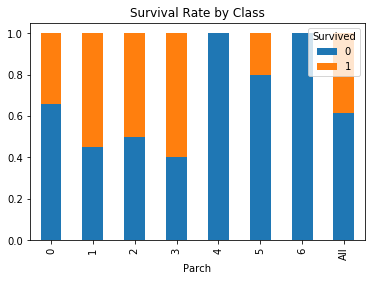

In [2831]:
survivedByParchITable.plot(kind='bar', stacked=True, title='Survival Rate by Class')

survivedByParchITable

In [2832]:
survivedByPClassParchTable=pandas.crosstab([train_df['Parch'],train_df['Pclass']],
    train_df['Survived'],normalize=True)

In [2833]:
survivedByPClassParchTable

Survived             0         1
Parch Pclass                    
0     1       0.071829  0.111111
      2       0.096521  0.053872
      3       0.331089  0.096521
1     1       0.011223  0.023569
      2       0.008979  0.026936
      3       0.039282  0.022447
2     1       0.005612  0.017957
      2       0.003367  0.014590
      3       0.035915  0.012346
3     2       0.000000  0.002245
      3       0.002245  0.001122
4     1       0.001122  0.000000
      3       0.003367  0.000000
5     3       0.004489  0.001122
6     3       0.001122  0.000000

In [2834]:
survivedBySexParchTable=pandas.crosstab([train_df['Sex'],train_df['Parch']],
    train_df['Survived'],normalize='index')

In [2835]:
survivedBySexParchTable

Survived             0         1
Sex    Parch                    
female 0      0.211340  0.788660
       1      0.233333  0.766667
       2      0.387755  0.612245
       3      0.250000  0.750000
       4      1.000000  0.000000
       5      0.750000  0.250000
       6      1.000000  0.000000
male   0      0.834711  0.165289
       1      0.672414  0.327586
       2      0.677419  0.322581
       3      1.000000  0.000000
       4      1.000000  0.000000
       5      1.000000  0.000000

### Survival Rates By Spouse/Sibling



In [2836]:
survivedBySibSpITable=pandas.crosstab(train_df['SibSp'],train_df['Survived'],margins=True,normalize='index')

Survived,0,1
SibSp,,
0,0.654605,0.345395
1,0.464115,0.535885
2,0.535714,0.464286
3,0.750000,0.250000
4,0.833333,0.166667
5,1.000000,0.000000
8,1.000000,0.000000
All,0.616162,0.383838


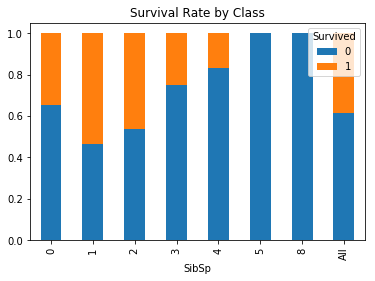

In [2837]:
survivedBySibSpITable.plot(kind='bar', stacked=True, title='Survival Rate by Class')

survivedBySibSpITable

Survival rates appear higher for those travelling with one are two people.

In [2838]:
survivedByPClassSibSpTable=pandas.crosstab([train_df['Pclass'],train_df['SibSp']],
    train_df['Survived'],normalize='index')

In [2839]:
survivedByPClassSibSpTable

Survived             0         1
Pclass SibSp                    
1      0      0.437956  0.562044
       1      0.253521  0.746479
       2      0.200000  0.800000
       3      0.333333  0.666667
2      0      0.583333  0.416667
       1      0.418182  0.581818
       2      0.500000  0.500000
       3      0.000000  1.000000
3      0      0.763533  0.236467
       1      0.674699  0.325301
       2      0.666667  0.333333
       3      0.916667  0.083333
       4      0.833333  0.166667
       5      1.000000  0.000000
       8      1.000000  0.000000

### Survival Rates By Age

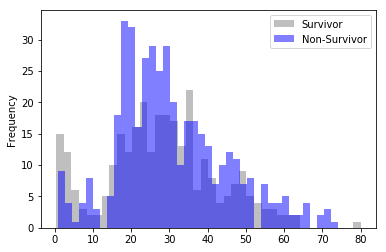

In [2840]:
survived_index=train_df['Survived']==1
train_df["Age"].loc[survived_index].plot.hist(alpha=0.5,color='grey',bins=40)
train_df["Age"].loc[~survived_index].plot.hist(alpha=0.5,color='blue',bins=40)
plt.legend(['Survivor','Non-Survivor'])
plt.show()

We can see that the distribution of age for survivors differs from the distribution of age for non-survivors. We see that children less than 10 are over-represented in the survivors. This likely reflects a 'women and children first' policy when loading life boats. Based on this information we create a categorical variable for age range.

In [2841]:
missingValue=-0.5
bins = [-1,0,5,12,18,35,60,100]
labelNames = ["Missing","0_5","5_12","12_18","18_35","35_60","60_100"]
train_df["AgeFilled"] = train_df["Age"].fillna(missingValue)
train_df["ageGroup"] = pandas.cut(train_df["AgeFilled"],bins,labels=labelNames)


Children between the ages of 0 and 5, which represent roughly 5% of the Titanic population, had survival rates of 70%.

In [2842]:
survivedByAgeGroupTable=pandas.crosstab(train_df['ageGroup'],train_df['Survived'],
    margins=True,normalize='all')

survivedByAgeGroupITable=pandas.crosstab(train_df['ageGroup'],train_df['Survived'],
    margins=True,normalize='index')

In [2843]:
survivedByAgeGroupTable

Survived,0,1,All
ageGroup,,,
Missing,0.140292,0.058361,0.028058
0_5,0.014590,0.034792,0.078563
5_12,0.017957,0.010101,0.218855
12_18,0.044893,0.033670,0.401796
18_35,0.248036,0.153760,0.198653
35_60,0.131313,0.087542,0.049383
60_100,0.019080,0.005612,0.024691
All,0.616162,0.383838,1.000000


Survived,0,1
ageGroup,,
Missing,0.706215,0.293785
0_5,0.295455,0.704545
5_12,0.640000,0.360000
12_18,0.571429,0.428571
18_35,0.617318,0.382682
35_60,0.600000,0.400000
60_100,0.772727,0.227273
All,0.616162,0.383838


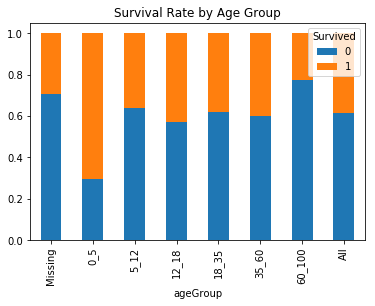

In [2844]:
survivedByAgeGroupITable.plot(kind='bar', stacked=True, title='Survival Rate by Age Group')

survivedByAgeGroupITable

We Further subdivide survivor rates by gender:

In [2845]:
survivedBySexAgeGroupTable=pandas.crosstab([train_df['Sex'],train_df['ageGroup']],
    train_df['Survived'],normalize='all')

In [2846]:
survivedBySexAgeGroupTable

Survived                0         1
Sex    ageGroup                    
female Missing   0.019080  0.040404
       0_5       0.005612  0.017957
       5_12      0.008979  0.003367
       12_18     0.010101  0.030303
       18_35     0.029181  0.105499
       35_60     0.017957  0.060606
       60_100    0.000000  0.003367
male   Missing   0.121212  0.017957
       0_5       0.008979  0.016835
       5_12      0.008979  0.006734
       12_18     0.034792  0.003367
       18_35     0.218855  0.048260
       35_60     0.113356  0.026936
       60_100    0.019080  0.002245

In [2847]:
survivedBySexAgeGroupITable=pandas.crosstab([train_df['Sex'],train_df['ageGroup']],
    train_df['Survived'],normalize='index')

In [2848]:
survivedBySexAgeGroupITable

Survived                0         1
Sex    ageGroup                    
female Missing   0.320755  0.679245
       0_5       0.238095  0.761905
       5_12      0.727273  0.272727
       12_18     0.250000  0.750000
       18_35     0.216667  0.783333
       35_60     0.228571  0.771429
       60_100    0.000000  1.000000
male   Missing   0.870968  0.129032
       0_5       0.347826  0.652174
       5_12      0.571429  0.428571
       12_18     0.911765  0.088235
       18_35     0.819328  0.180672
       35_60     0.808000  0.192000
       60_100    0.894737  0.105263

Survivor rates were just above 65% for male children between 0 and 5 in age. For female children survivor rates are nearly uniform across age ranges. Oddly, survivor rates drop to just 27% for female children between the ages of 5 and 12, however, there were actually very few passengers observed in that age range, particularly female children.

### Survival Rates By Sex

Next we examine the survival rates by gender.

In [2849]:
survivedBySexITable=pandas.crosstab(train_df['Sex'],train_df['Survived'],margins=True,normalize='index')

Survived,0,1
Sex,,
female,0.257962,0.742038
male,0.811092,0.188908
All,0.616162,0.383838


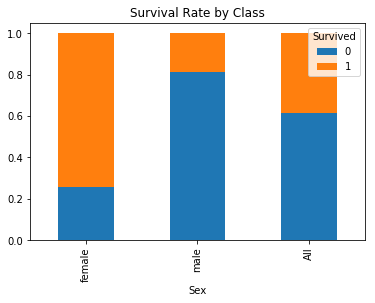

In [2850]:
survivedBySexITable.plot(kind='bar', stacked=True, title='Survival Rate by Class')

survivedBySexITable

We see that survivor rates were 74% for women as compared to 19% for men. In other words, 81% of those who perished were male. 

### Survival Rates By Class

We tabulate the proportions of each population - i.e., perished, survived, total population - by class.

In [2851]:
survivedByPclass=pandas.crosstab(train_df['Pclass'],train_df['Survived'],margins=False,normalize=True)

survivedByPclassTable=pandas.crosstab(train_df['Pclass'],train_df['Survived'],margins=True,normalize=True)


In [2852]:
survivedByPclassTable

Survived,0,1,All
Pclass,,,
1,0.089787,0.152637,0.242424
2,0.108866,0.097643,0.206510
3,0.417508,0.133558,0.551066
All,0.616162,0.383838,1.000000


We also compute survival rates by class.

In [2853]:
survivedByPclassCTable=pandas.crosstab(train_df['Pclass'],train_df['Survived'],margins=True,normalize='columns')

Survived,0,1,All
Pclass,,,
1,0.145719,0.397661,0.242424
2,0.176685,0.254386,0.206510
3,0.677596,0.347953,0.551066


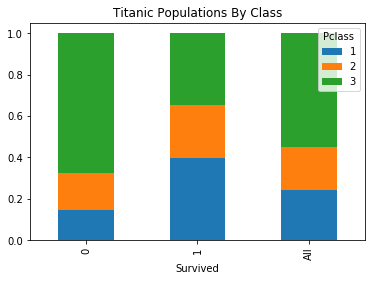

In [2854]:
survivedByPclassCTable.T.plot(kind='bar', stacked=True, title='Titanic Populations By Class')

survivedByPclassCTable

Although third class passengers made up a little more than half (55%) of those onboard the Titanic when it sank, they comprised roughly 68% of those that perished (i.e., roughly 42% of the 62% of passengers that did not survive). First class passengers comprised 24% of the Titanic population, but 40% of survivors.

To see this from a different perspective we tabulate the survival rates by class:

In [2855]:
survivedByPclassITable=pandas.crosstab(train_df['Pclass'],train_df['Survived'],margins=True,normalize='index')

Survived,0,1
Pclass,,
1,0.370370,0.629630
2,0.527174,0.472826
3,0.757637,0.242363
All,0.616162,0.383838


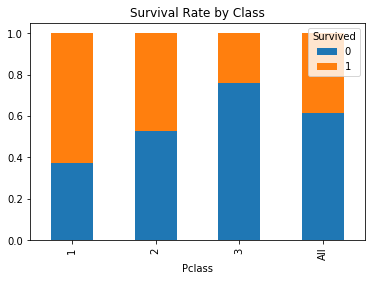

In [2856]:
survivedByPclassITable.plot(kind='bar', stacked=True, title='Survival Rate by Class')

survivedByPclassITable

We can see that the survival rate declines as we move lower in class.

### Proportion of Survivors and Non-Survivors by Sex and Class

We compute the proportion of survivors and non-survivors by sex and class:

In [2857]:
survivedBySexPClassTable=pandas.crosstab([train_df['Sex'],train_df['Pclass']],
    train_df['Survived'],normalize='index')

In [2858]:
survivedBySexPClassTable

Survived              0         1
Sex    Pclass                    
female 1       0.031915  0.968085
       2       0.078947  0.921053
       3       0.500000  0.500000
male   1       0.631148  0.368852
       2       0.842593  0.157407
       3       0.864553  0.135447

Drilling into gender and class of passengers, we observe that nearly all of the third and second class men perished (87% and 84% percent respectively). First class men faired a bit better with 63% not surviving. Only half of the third class women died. Almost all first and second class women survived (97% and 92% respectively).

### Fare By Sex for Survivor and Non-Survivor Populations

Examining the fare by gender for survivor and non-survivor populations, we again see female survivors tended to pay higher fares. We would expect the 'Fare' variable to be highly correlated with the 'Pclass' and 'cLevel' categorial variables.

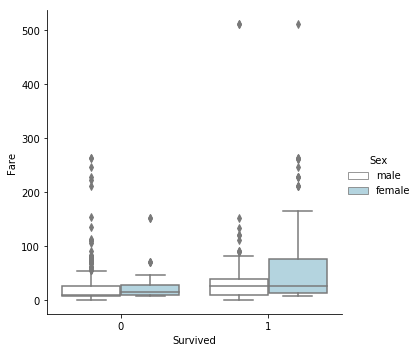

In [2859]:
g = seaborn.catplot("Survived", "Fare", "Sex", data=train_df, kind="box",
    palette=["white","lightblue"])
g.set_axis_labels("Survived", "Fare");

### Distribution of Age By Sex for Survivor and Non-Survivor Populations

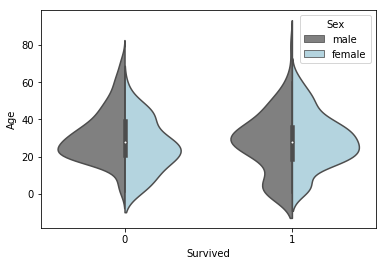

In [2860]:
seaborn.violinplot(y = "Age",x='Survived',hue="Sex",split=True,data=train_df,alpha=0.75,
    palette=["grey","lightblue"])

Survival rates are higher among male children.

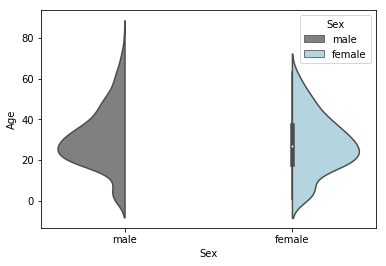

In [2861]:
seaborn.violinplot(y = "Age",x='Sex',hue='Sex',split=True,data=train_df,
    alpha=0.75,palette=["grey","lightblue"])

### Class and Level for Survivor and Non-Survivor Populations

We examine the correspondence of class with level.

We tabulate the proportion of the Titanic population for survivors and non-survivors by class and level:

In [2862]:
survivedByPClassLevelTable=pandas.crosstab([train_df['Pclass'],train_df['cLevel']],
    train_df['Survived'].values,normalize='all')

In [2863]:
survivedByPClassLevelTable

col_0                  0         1
Pclass cLevel                     
1      A        0.008979  0.007856
       B        0.010101  0.030303
       BB       0.002245  0.005612
       BBB      0.001122  0.001122
       BBBB     0.000000  0.002245
       C        0.022447  0.034792
       CC       0.002245  0.002245
       CCC      0.002245  0.002245
       D        0.007856  0.023569
       DD       0.000000  0.001122
       E        0.007856  0.020202
       Missing  0.023569  0.021324
       T        0.001122  0.000000
2      D        0.001122  0.003367
       E        0.001122  0.003367
       F        0.001122  0.007856
       Missing  0.105499  0.083053
3      E        0.000000  0.003367
       F        0.001122  0.000000
       FE       0.000000  0.001122
       FG       0.003367  0.000000
       G        0.002245  0.002245
       Missing  0.410774  0.126824

We can see that 'PClass' is related to 'cLevel'. We see that there are more missing 'cLevel' values for lower classes.

### Survival Rates By Embarked Code

The vast majority (72%) of passengers embarked from the location denoted by the embarked code 'S'.

In [2864]:
survivedByEmbarkedTable=pandas.crosstab([train_df['Embarked']],
    train_df['Survived'].values,normalize='all',margins=True)

In [2865]:
survivedByEmbarkedTable

col_0,0,1,All
Embarked,,,
C,0.084364,0.104612,0.188976
Q,0.052868,0.033746,0.086614
S,0.480315,0.244094,0.724409
All,0.617548,0.382452,1.000000


Examining the survival rates by embarked code we see that the code is unlikely to be a strong predictor of survival.

In [2866]:
survivedByEmbarkedITable=pandas.crosstab([train_df['Embarked']],
    train_df['Survived'].values,normalize='index',margins=True)

col_0,0,1
Embarked,,
C,0.446429,0.553571
Q,0.610390,0.389610
S,0.663043,0.336957
All,0.617548,0.382452


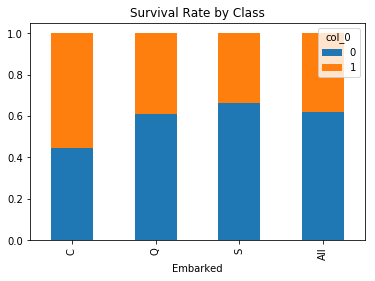

In [2867]:
survivedByEmbarkedITable.plot(kind='bar', stacked=True, title='Survival Rate by Class')

survivedByEmbarkedITable

Class imbalance likely explains the slight advantage in departing from the location denoted by 'C'.

In [2868]:
survivedByPClassEmbarkedTable=pandas.crosstab([train_df['Pclass'],train_df['Embarked']],
    train_df['Survived'].values,normalize=True)

In [2869]:
survivedByPClassEmbarkedTable

col_0                   0         1
Pclass Embarked                    
1      C         0.029246  0.066367
       Q         0.001125  0.001125
       S         0.059618  0.083240
2      C         0.008999  0.010124
       Q         0.001125  0.002250
       S         0.098988  0.085489
3      C         0.046119  0.028121
       Q         0.050619  0.030371
       S         0.321710  0.075366

### Fare Distributions By Sex for Survivor and Non-Survivor Populations

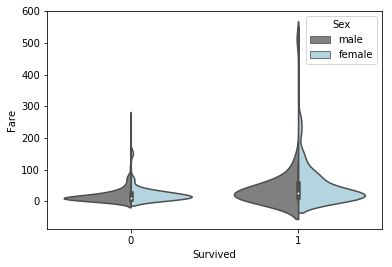

In [2870]:
seaborn.violinplot(y = "Fare",x='Survived',hue="Sex",split=True,data=train_df,
    palette=["grey","lightblue"])

### Age and Class Distributions for Surviving and Non-Surviving Populations

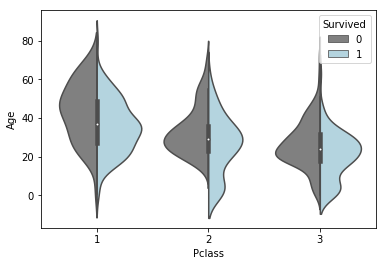

In [2871]:
seaborn.violinplot(y = "Age",x="Pclass",hue="Survived",split=True,data=train_df,alpha=0.75,
    palette=["grey","lightblue"])

We can see that the age distributions of survivors and non-survivors differ significantly by class. Lower class survivors tended to be young, likely reflecting a 'women and children' first policy. Interestingly, the disparity in the modes of the survivor and non-survivor distributions increases with class. Upper class passengers tended to be older than middle and lower class passengers. Older upper class passengers were more likely to perish then younger upper class passengers.

### Relationship Between Fare and Class for Surviving and Non-Surviving Populations

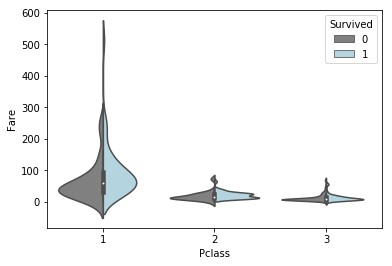

In [2872]:
seaborn.violinplot(y = "Fare",x="Pclass",hue="Survived",split=True,data=train_df,alpha=0.75,
    palette=["grey","lightblue"])

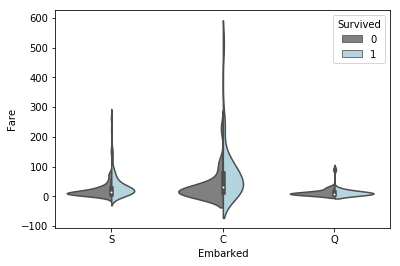

In [2873]:
seaborn.violinplot(y = "Fare",x="Embarked",hue="Survived",split=True,data=train_df,alpha=0.75,
    palette=["grey","lightblue"])

## Model Training

In this section, we select features based on the use the exploratory data analysis (EDA) of the previous section, then train a model to classify Titanic passengers as either survivors or non-survivors based on the selected predictors. This will be the basis for the train_model.py script to be developed.

In [2874]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Level,nRooms,cLevel,AgeFilled,ageGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,NaN,0.0,Missing,22.0,18_35
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,[C],1.0,C,38.0,35_60
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,NaN,0.0,Missing,26.0,18_35
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,[C],1.0,C,35.0,18_35
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,NaN,0.0,Missing,35.0,18_35


We convert a number of categorical variables into dummy variables:

In [2875]:
# define functions for adding dummy variables
def addDummyVariable(df,columnName):
    df = pandas.concat([df,pandas.get_dummies(df[columnName],prefix=columnName)],axis=1)
    return df

def iterateAddDummyVariables(df,columnNames):
    for columnName in columnNames:
        df = addDummyVariable(df,columnName)    
    return df

# define columns for conversion to dummy variables
dummyColumnNames=['Sex','Pclass','ageGroup','SibSp','Parch']
# create dummy variables for gender, class, age group, embarked code, sibling/spouse,
df_train=iterateAddDummyVariables(train_df,dummyColumnNames)
# drop unneeded predictors 
df_train.drop(['PassengerId','Pclass','Name','Sex','SibSp','Parch','Ticket',
    'Age','AgeFilled','ageGroup','Cabin','Embarked','Level','cLevel','Sex_male'], axis=1,
    inplace=True)

We dropped the 'Name' and 'Embarked' variables without deriving any features from these fields. 'Embarked' appeared to be independent of survival rates in the exploratory data analysis. 'Name' could likely be used to create features indicating the social status of an individual, but such features were not explored.

Features were derived from 'Age' (i.e., 'ageGroup') and 'Cabin' (i.e., nRooms). Dummy variables were created from 'Pclass', 'Sex', 'ageGroup', 'Parch', and 'SibSp'.

Fare was included without any processing

In [2876]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 28 columns):
Survived            891 non-null int64
Fare                891 non-null float64
nRooms              891 non-null float64
Sex_female          891 non-null uint8
Pclass_1            891 non-null uint8
Pclass_2            891 non-null uint8
Pclass_3            891 non-null uint8
ageGroup_Missing    891 non-null uint8
ageGroup_0_5        891 non-null uint8
ageGroup_5_12       891 non-null uint8
ageGroup_12_18      891 non-null uint8
ageGroup_18_35      891 non-null uint8
ageGroup_35_60      891 non-null uint8
ageGroup_60_100     891 non-null uint8
SibSp_0             891 non-null uint8
SibSp_1             891 non-null uint8
SibSp_2             891 non-null uint8
SibSp_3             891 non-null uint8
SibSp_4             891 non-null uint8
SibSp_5             891 non-null uint8
SibSp_8             891 non-null uint8
Parch_0             891 non-null uint8
Parch_1             891 non-null 

In [2877]:
df_train.head()

,Survived,Fare,nRooms,Sex_female,Pclass_1,Pclass_2,Pclass_3,ageGroup_Missing,ageGroup_0_5,ageGroup_5_12,...,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
0,0,7.2500,0.0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1,71.2833,1.0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,7.9250,0.0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,53.1000,1.0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,8.0500,0.0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


We specifically created a dummy variable for missing values of 'Age'. Missing values for 'nRooms' were encoded with zero based on the idea that missing room information could indicate lower social status. Higher numbers of rooms might reflect higher social status. 

We added an imputer for missing values mainly to handle potential missing values in hold-out data, using the most frequent value as the strategy.

In [2878]:
# define imputation
rf_impute = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
# define random forest classifier
rf = RandomForestClassifier(max_depth=10, min_samples_split=2, n_estimators=100, random_state=randomSeed)
# build pipeline
pipeline = Pipeline([('imputation', rf_impute), ('random_forest', rf)])

Our pipeline includes the imputation strategy and the random forest classifier defined with hyper-parameters. Not optimization was done for the selection of hyper-parameters, but ad hoc sensitivity analysis revealed low sensitivity to small perturbations of the parameters around the values selected.

In [2879]:
# extract predictors
X = df_train.drop("Survived",axis=1)
# extract target
y = df_train["Survived"]

We split the training data into training and testing sets, then we fit the model defined above on the training set:

In [2880]:
# set aside 40% of the training set for testing
testSize=0.4
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize, 
    random_state=randomSeed)
# fit model using pipeline defined above
rf_model = pipeline.fit(X_train, y_train)

We reserve 40% of the training set for out-of-sample testing.

In [2881]:
X_train.head()

,Fare,nRooms,Sex_female,Pclass_1,Pclass_2,Pclass_3,ageGroup_Missing,ageGroup_0_5,ageGroup_5_12,ageGroup_12_18,...,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
544,106.4250,1.0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
875,7.2250,0.0,1,0,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
670,39.0000,0.0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
772,10.5000,1.0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
202,6.4958,0.0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


Compute in-sample (training) scoring metrics:

In [2882]:
# compute accuracy for model on training set
score_train = rf_model.score(X_train, y_train)
# create training set predictions
y_pred_train = rf_model.predict(X_train)
# create training set classification report
class_report_train = classification_report(y_train, y_pred_train)

In-sample performance metrics were relatively good. We expect significantly lower scores on the out-of-sample (test set) data.

In [2883]:
print(class_report_train)

             precision    recall  f1-score   support

          0       0.92      0.98      0.95       333
          1       0.97      0.86      0.91       201

avg / total       0.94      0.94      0.94       534



## Model Testing

In this section, we test the model developed in the previous section using out-of-sample data (i.e., the test set). We also examine the variability of our accuracy metric using cross-validation.

First, we define some functions to normalize and visualize the confusion matrix:

In [2884]:
def normalize_confusion_matrix(cm):
    # normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
    # return confusion matrix
    return cm

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    Plots the confusion matrix. Set `normalize=True` for normalization.
    """
    if normalize:
        cm = normalize_confusion_matrix(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    return

def plot_both_confusion_matrix(cm,label_names):
    # size figure
    plt.figure(figsize=(15,10))
    # add first subplot
    plt.subplot(2, 2, 1)
    # plot confusion matrix
    plot_confusion_matrix(cm,classes=label_names,normalize=False)
    # add second subplot
    plt.subplot(2, 2, 2)
    # plot confusion matrix (normalized)
    plot_confusion_matrix(cm,classes=label_names,normalize=True)
    
    return

Next, we compute scoring metrics for the model on the test set:

In [2885]:
# compute accuracy for model on test set
score_test = rf_model.score(X_test, y_test)
# create test set predictions
y_pred = rf_model.predict(X_test)
# create classification report
class_report_test = classification_report(y_test, y_pred)


The accuracy of the model is reasonably high, beating a naive labeling of all passengers as non-survivors.

In [2886]:
print("Accuracy: %0.2f " % (score_test))

Accuracy: 0.80 


In [2887]:
print(class_report_test)

             precision    recall  f1-score   support

          0       0.81      0.88      0.85       216
          1       0.79      0.68      0.73       141

avg / total       0.80      0.80      0.80       357



Now we evaluate the expected variation in the model accuracy using cross-validation with 5 folds: 

In [2888]:
# define number of folds
nFolds=5
# compute cross validation score for each of nFolds different splits
scores = cross_val_score(rf_model, X, y, cv=nFolds)

In [2905]:
y

0      0
1      1
2      1
3      1
4      0
5      0
6      0
7      0
8      1
9      1
10     1
11     1
12     0
13     0
14     0
15     1
16     0
17     1
18     0
19     1
20     0
21     1
22     1
23     1
24     0
25     1
26     0
27     0
28     1
29     0
      ..
861    0
862    1
863    0
864    0
865    1
866    1
867    0
868    0
869    1
870    0
871    1
872    0
873    0
874    1
875    1
876    0
877    0
878    0
879    1
880    1
881    0
882    0
883    0
884    0
885    0
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

Compute mean score and the 95% confidence interval of the score estimate:

In [2889]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.82 (+/- 0.06)


Examining the confusion matrix, we can see that the model is able to correctly label 88% of the non-survivors, but only 68% of the survivors.

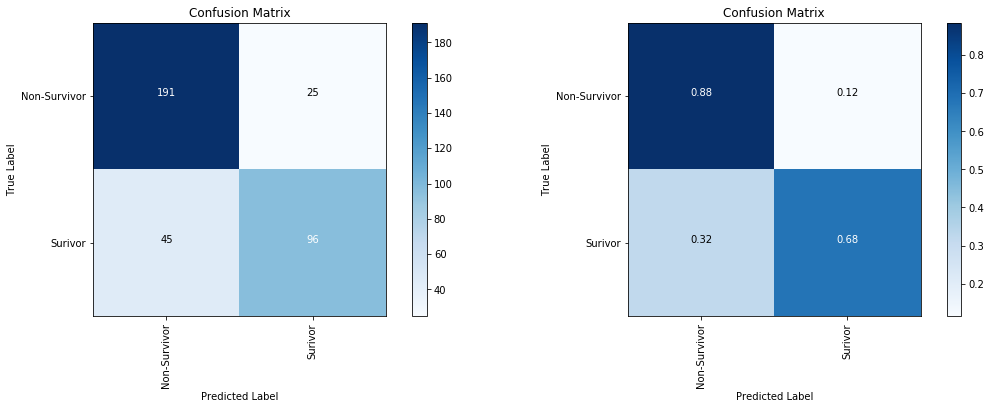

In [2890]:
# compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# define labels
label_names=['Non-Survivor','Surivor']
# plot non-normalized and normalized confusion matrix
plot_both_confusion_matrix(cm,label_names)
#

Finally, we look at feature importance:

In [2891]:
def featureImportance(rf,X):
    importances = rf.feature_importances_
    columnNames=X.columns.values
    featureImportanceDf=pandas.DataFrame(importances,index=columnNames,columns=['featureImportance'])
    
    return featureImportanceDf


In [2892]:
featureImportanceDf=featureImportance(rf,X)

Our model makes intuitive sense, with high feature importance found for features indicating whether a passenger is female, low class, or the age group 18-35 or 0 to 5. The magnitude of the fare paid has the second highest importance.

Text(0.5,0,'Feature Importance (%)')

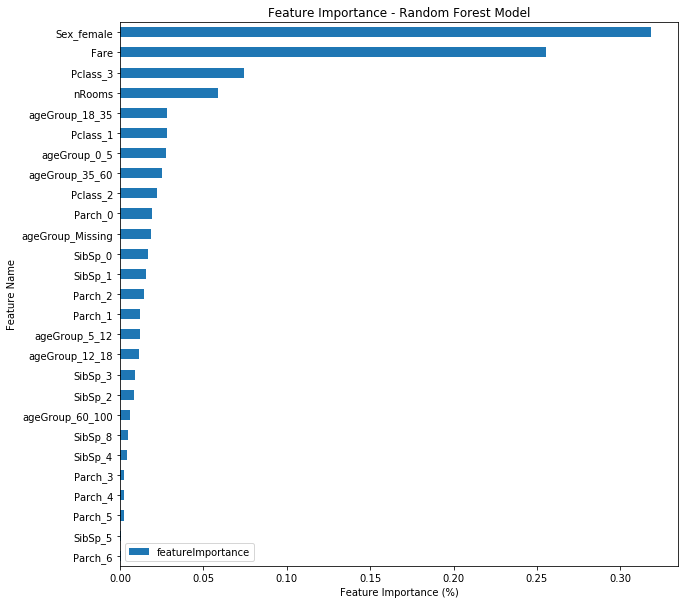

In [2893]:
featureImportanceDf.sort_values(by='featureImportance',ascending=True).plot(kind='barh',figsize=(10,10))
plt.title('Feature Importance - Random Forest Model')
plt.ylabel("Feature Name")
plt.xlabel("Feature Importance (%)")

In [2894]:
featureImportanceDf.sort_values(by='featureImportance',ascending=False)

,featureImportance
Sex_female,0.318607
Fare,0.255487
Pclass_3,0.074525
nRooms,0.058651
ageGroup_18_35,0.028408
Pclass_1,0.028365
ageGroup_0_5,0.027595
ageGroup_35_60,0.025303
Pclass_2,0.021963
Parch_0,0.019349


Define function to show feature importance on command line:

In [2895]:
def printFeatureImportance(rf,X):
    importances = rf.feature_importances_
    columnNames=X.columns.values
    indices = numpy.argsort(importances)[::-1]
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature: %s (%f)" % (f + 1, columnNames[indices[f]], importances[indices[f]]))
    
    return


In [2896]:
printFeatureImportance(rf,X)

Feature ranking:
1. feature: Sex_female (0.318607)
2. feature: Fare (0.255487)
3. feature: Pclass_3 (0.074525)
4. feature: nRooms (0.058651)
5. feature: ageGroup_18_35 (0.028408)
6. feature: Pclass_1 (0.028365)
7. feature: ageGroup_0_5 (0.027595)
8. feature: ageGroup_35_60 (0.025303)
9. feature: Pclass_2 (0.021963)
10. feature: Parch_0 (0.019349)
11. feature: ageGroup_Missing (0.018720)
12. feature: SibSp_0 (0.016565)
13. feature: SibSp_1 (0.015623)
14. feature: Parch_2 (0.014419)
15. feature: Parch_1 (0.012207)
16. feature: ageGroup_5_12 (0.012121)
17. feature: ageGroup_12_18 (0.011560)
18. feature: SibSp_3 (0.008771)
19. feature: SibSp_2 (0.008181)
20. feature: ageGroup_60_100 (0.005894)
21. feature: SibSp_8 (0.004628)
22. feature: SibSp_4 (0.004520)
23. feature: Parch_3 (0.002546)
24. feature: Parch_4 (0.002459)
25. feature: Parch_5 (0.002177)
26. feature: SibSp_5 (0.000708)
27. feature: Parch_6 (0.000647)
